# Import Libraries

In [ ]:
import tensorflow as tf
import os
import glob
import random
import math

# Load Data

## Function to load and preprocess images

In [ ]:
def load_image(image_path, mask_path):
    # Load image and mask
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)  # Normalize to [0, 1]

    return image, mask

## Function to build a 2D transformation matrix

In [ ]:
def build_2d_transform_matrix(flip=None, offset=None, scale=None, rotate=None):
    transform = tf.eye(3)

    # Apply flip
    if flip and random.random() > 0.5:
        transform = tf.linalg.tensor_diag([flip, flip, 1.0]) @ transform
        # flip=-1 in x, flip=1 without change - flip=-1 in y - مقدار همگنی

    # Apply offset
    if offset:
        offset_x = random.uniform(-offset, offset)
        offset_y = random.uniform(-offset, offset)
        offset_matrix = tf.convert_to_tensor([[1, 0, offset_x],
                                              [0, 1, offset_y],
                                              [0, 0, 1]], dtype=tf.float32)
        transform = offset_matrix @ transform
        # if offset is a random number x (offset_x) , y (offset_y) generate ofset in range [-offset, offset]

    # Apply scale
    if scale:
        scale_x = 1.0 + random.uniform(-scale, scale)
        scale_y = 1.0 + random.uniform(-scale, scale)
        scale_matrix = tf.convert_to_tensor([[scale_x, 0, 0],
                                             [0, scale_y, 0],
                                             [0, 0, 1]], dtype=tf.float32)
        transform = scale_matrix @ transform
        # in range [1 - scale, 1 + scale]

    # Apply rotation
    if rotate:
        angle_rad = random.uniform(-rotate, rotate) * math.pi / 180
        rotation_matrix = tf.convert_to_tensor([[tf.cos(angle_rad), -tf.sin(angle_rad), 0],
                                                [tf.sin(angle_rad), tf.cos(angle_rad), 0],
                                                [0, 0, 1]], dtype=tf.float32)
        transform = rotation_matrix @ transform
        # in range [-rotate, rotate]

    # Extract the 2x3 part of the matrix and flatten it to [6]
    transform = transform[:2, :]
    transform = tf.reshape(transform, [6])

    # Append [0, 0] to make it [8] elements
    transform = tf.concat([transform, tf.constant([0.0, 0.0])], axis=0)

    return transform

## Function to apply data augmentation

In [ ]:
def data_augmentation(image, mask, flip=None, offset=None, scale=None, rotate=None, noise=None):
    # Build the 2D transformation matrix
    transform_matrix = build_2d_transform_matrix(flip, offset, scale, rotate)

    # The transformation matrix needs to be in shape [1, 8]
    transform_matrix = tf.reshape(transform_matrix, [1, 8])

    # Apply affine transformation using ImageProjectiveTransformV2
    image_shape = tf.shape(image)[:2]
    image = tf.raw_ops.ImageProjectiveTransformV2(
        images=tf.expand_dims(image, 0),
        transforms=transform_matrix,
        output_shape=image_shape,
        interpolation="BILINEAR")[0]

    mask = tf.raw_ops.ImageProjectiveTransformV2(
        images=tf.expand_dims(mask, 0), # convert to [1, height, width, channels]
        transforms=transform_matrix,
        output_shape=image_shape,
        interpolation="NEAREST")[0]

    # Apply random noise
    if noise:
        noise_tensor = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise, dtype=tf.float32)
        image = tf.add(image, noise_tensor)

    return image, tf.cast(mask > 0.5, tf.float32) # in mask همه مقادیر بزرگتر از 0.5 را به 1 و بقیه را به 0 تبدیل می‌کند

## Shuffle and split the data

In [ ]:
# Directory paths
image_dir = 'C:/PC/Filoger/DL_Nonprofit/Prj/Code/DATA/frames/'
mask_dir = 'C:/PC/Filoger/DL_Nonprofit/Prj/Code/DATA/masks/'

In [ ]:
# Get list of image and mask file paths
image_paths = glob.glob(os.path.join(image_dir, '*.png'))
mask_paths = [os.path.join(mask_dir, os.path.basename(im)) for im in image_paths]

In [ ]:
# Shuffle and split the data
N = len(image_paths)
ixRand = list(range(N)) # list of 0 to N−1
random.shuffle(ixRand)

train_image_paths = [image_paths[i] for i in ixRand[:round(N * 0.8)]]
train_mask_paths = [mask_paths[i] for i in ixRand[:round(N * 0.8)]]

val_image_paths = [image_paths[i] for i in ixRand[round(N * 0.8):]]
val_mask_paths = [mask_paths[i] for i in ixRand[round(N * 0.8):]]

## Create TensorFlow Datasets

In [ ]:
# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))

## Apply loading and preprocessing functions

In [ ]:
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE) #map implement load_image on every element
train_dataset = train_dataset.map(lambda x, y: data_augmentation(x, y, flip=1, offset=0.1, scale=0.2, rotate=10, noise=0.1), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check loaded data
for image, mask in train_dataset.take(1):
    print(image.shape, mask.shape)

(32, 112, 112, 3) (32, 112, 112, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39769912..0.9418647].


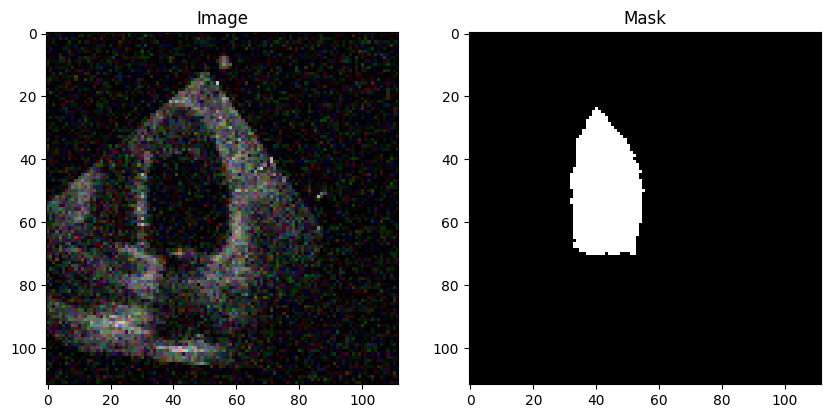

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.40769392..1.0329152].


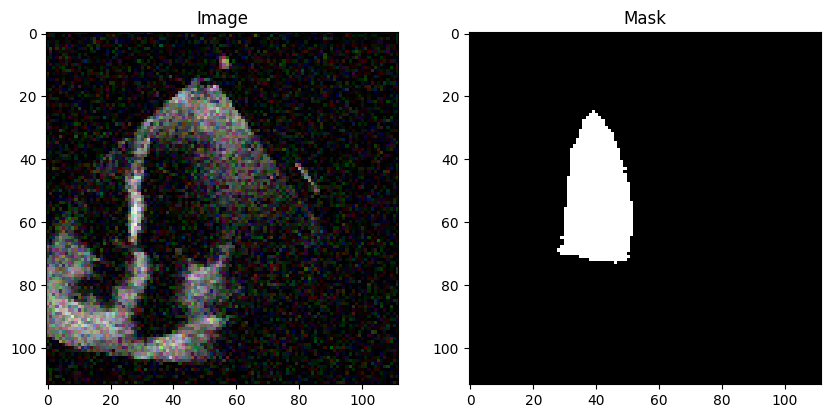

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3926159..1.0858785].


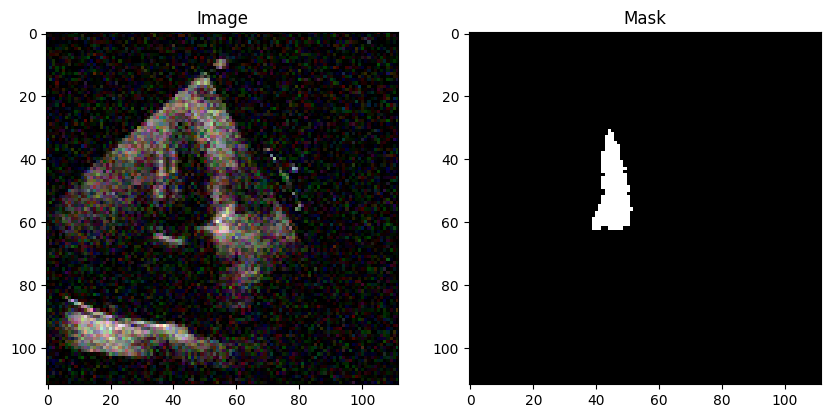

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to display image and mask
def display_image_mask(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap='gray')

    plt.show()

# Take a batch of images and masks from the dataset
for images, masks in train_dataset.take(1):
    for i in range(3):  # Display 3 images and their masks
        image = images[i].numpy()
        mask = masks[i].numpy()
        display_image_mask(image, mask)

# Model ---> U-Net

![u-net](unet.png)

In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow as tf
import keras
from keras import layers, Model

In [ ]:
# u-net
def unet_model(input_size=(256, 256, 3)):
    #input
    inputs = tf.keras.Input(input_size)
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    #bottelneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    #decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
model = unet_model(input_size=(256, 256, 3))

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_19 (Conv2D)            │ (None, 256, 256, 64)      │           1,792 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_20 (Conv2D)            │ (None, 256, 256, 64)      │          36,928 │ conv2d_19[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 128, 128, 64)      │               0 │ conv2d_20[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_21 (Conv2D)            │ (None, 128, 128, 128)     │          73,856 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_22 (Conv2D)            │ (None, 128, 128, 128)     │         147,584 │ conv2d_21[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 64, 64, 128)       │               0 │ conv2d_22[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_23 (Conv2D)            │ (None, 64, 64, 256)       │         295,168 │ max_pooling2d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_24 (Conv2D)            │ (None, 64, 64, 256)       │         590,080 │ conv2d_23[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 32, 32, 256)       │               0 │ conv2d_24[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_25 (Conv2D)            │ (None, 32, 32, 512)       │       1,180,160 │ max_pooling2d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_26 (Conv2D)            │ (None, 32, 32, 512)       │       2,359,808 │ conv2d_25[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_7               │ (None, 16, 16, 512)       │               0 │ conv2d_26[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_27 (Conv2D)            │ (None, 16, 16, 1024)      │       4,719,616 │ max_pooling2d_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_28 (Conv2D)            │ (None, 16, 16, 1024)      │       9,438,208 │ conv2d_27[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [ ]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
small_model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coef])

In [1]:
from tensorflow import keras
from keras import layers

# Swin Transformer Block
def swin_block(x, num_heads, window_size):
    # Layer Normalization
    x = layers.LayerNormalization()(x)

    # Self-Attention
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1])(x, x)

    # Skip Connection
    x = layers.Add()([x, attention_output])

    # MLP Block
    x = layers.LayerNormalization()(x)
    x = layers.Dense(x.shape[-1], activation='relu')(x)
    x = layers.Dense(x.shape[-1])(x)

    return layers.Add()([x, attention_output])

# Define Swin UNet
def swin_unet(input_size=(256, 256, 3), window_size=7, num_heads=4):
    inputs = keras.Input(input_size)

    # Encoder
    x = swin_block(inputs, num_heads, window_size)

    # Downsample (Patch Merging)
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(x)

    # Bottleneck
    x = swin_block(x, num_heads, window_size)

    # Decoder
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = swin_block(x, num_heads, window_size)

    # Output
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)
    return model

# Compile model
model = swin_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 256, 256, 3)    │              6 │ input_layer[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 256, 256, 3)    │            183 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 256, 3)    │              0 │ layer_normalization[0… │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 256, 256, 3)    │              6 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256, 256, 3)    │             12 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256, 256, 3)    │             12 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256, 256, 3)    │              0 │ dense_1[0][0],         │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 128, 128, 64)   │            128 │ conv2d[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 128, 128, 64)   │         66,368 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 128, 128, 64)   │              0 │ layer_normalization_2… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 128, 128, 64)   │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128, 128, 64)   │          4,160 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128, 128, 64)   │          4,160 │ dense_2[0][0]          │
├──────────────────────

 Total params: 188,892 (737.86 KB)

 Trainable params: 188,892 (737.86 KB)

 Non-trainable params: 0 (0.00 B)